In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")
### display all rows
pd.set_option('display.max_rows', None)

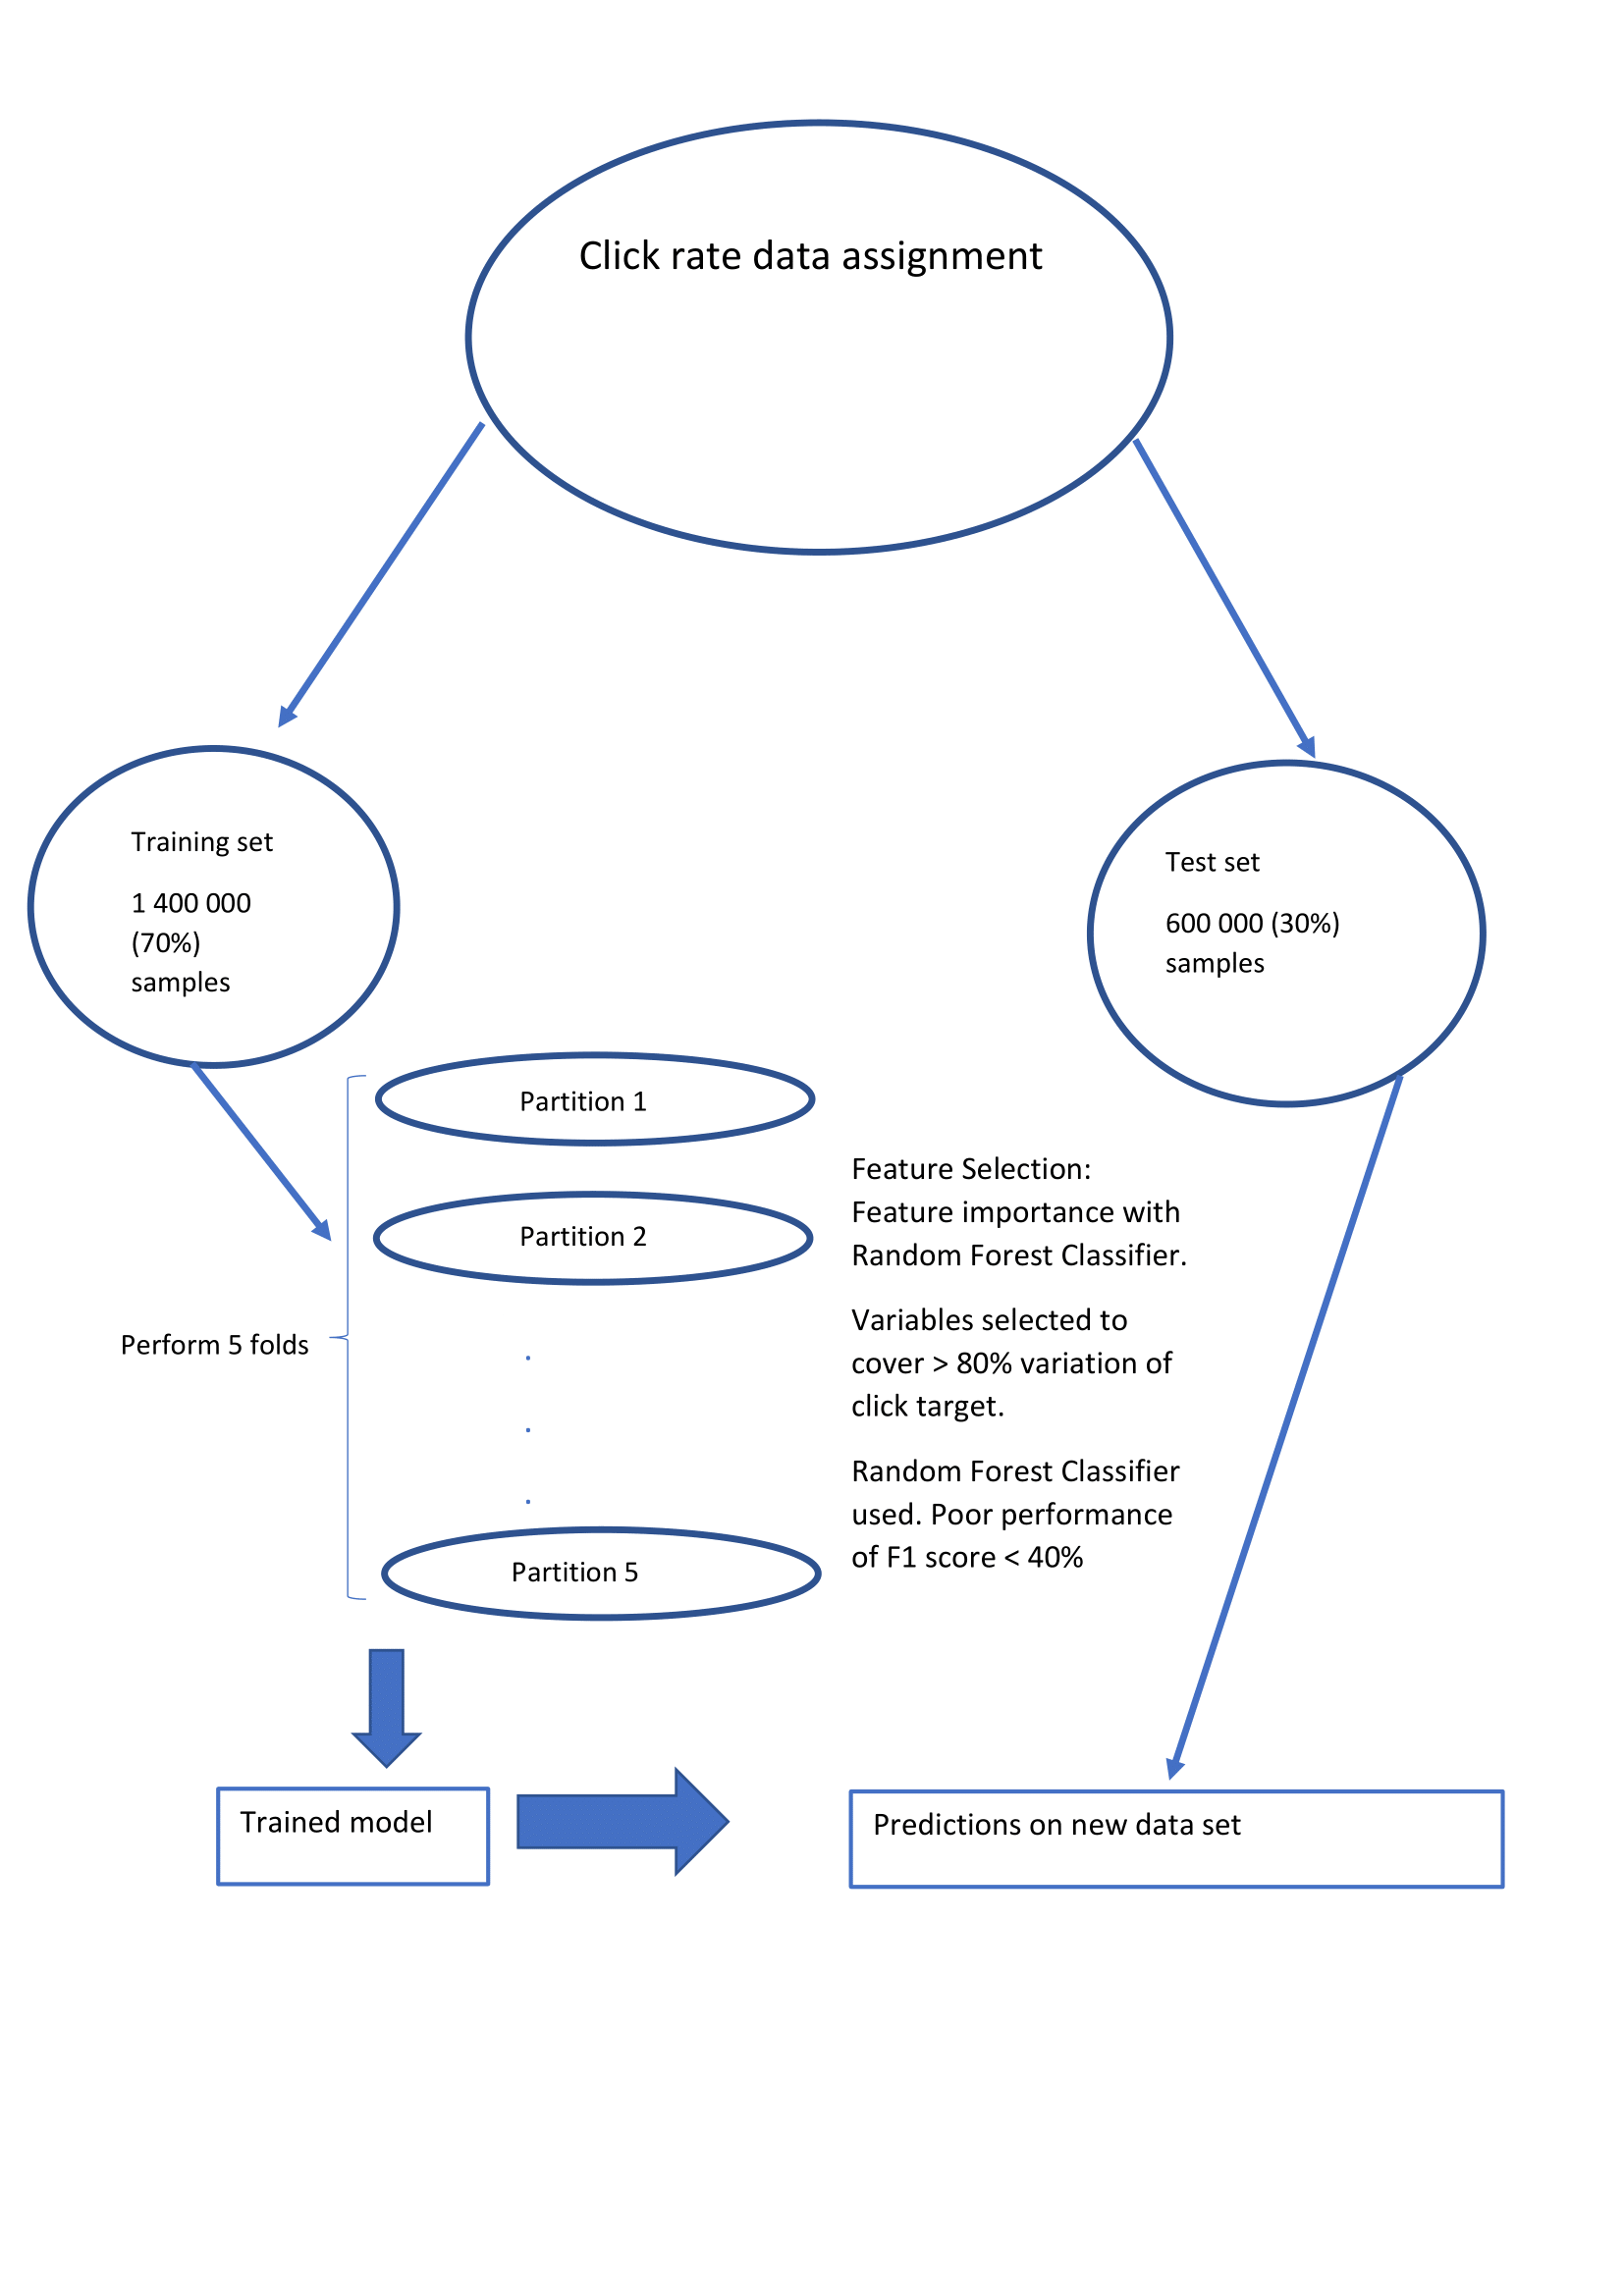

In [75]:

from IPython.display import Image

fig = Image(filename='FlowChart4JupyterNb-1.png')
fig

In [61]:
data = pd.read_csv("train")
data = data.drop_duplicates() ### Only unique records

In [23]:
# data.head()

| Field Name            | Description                                                   
|-----------------------|---------------------------------------------------------------
| id                    | listing Identifier for each listing advertisement             
| unix_timestamp        | time when click event occured.                                
| ui_component_position | Position on device where listing advertisement was displayed. 
| site_id               | partner sites where ad was shown.
| site_domain           | domain/country where partner site operates in.
| app_id                | special identifier for app used
| device_id             | special identifier for device used
| device_conn_type      | type of network connection used by device
| f0-f8                 | anonymized categorical variables
| click                 | Target variable (0/1). Where 1 - clicked, 0 - not clicked

### Check dimension of data, Nulls, and %target population.

In [24]:
# data.info()

In [63]:
print(0.3*data.shape[0])
data.shape

599999.7


(1999999, 24)

In [26]:
# data.isnull().sum()/len(data)

In [27]:
# data["click"].value_counts()/len(data)

### The missing values for f7 has a higher than click rate the overall average, hence it may prove worthwhile including it.

In [28]:
### function to change unix timestamp into datetime
def unix2datetime(x):
    timestamp = datetime.datetime.fromtimestamp(x)
    date_time_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S') #timestamp.strftime('%Y-%m-%d %H:%M:%S')

In [29]:

data["timeofclick"] = data["unix_timestamp"].apply(lambda x: unix2datetime(x))

In [30]:
data["weekday"] = data["timeofclick"].apply(lambda x: x.weekday())
data["hour"] = data["timeofclick"].apply(lambda x: x.hour)

# Sample code below to store levels you want to csv and recode later for production

In [31]:

def recode_func(x, lst):
    res = 'Other'
    if (x in lst):
        res = x
    return res


### f variables. 

In [32]:
### Replace Nulls in f7 variable
# data["f7"] = np.where(data["f7"].isnull(), 99999, data["f7"])
### Found f7 only add value if null
data["f7"] = np.where(data["f7"].isnull(), 1, 0)

ls_fx = ["f"+str(i) for i in np.arange(9)]
    
### force f variables to object type    
for k in ls_fx:
    data[k] = data[k].astype(str)


# Encode all cat variables

In [34]:
%%time 
# var = ['site_id', 'site_domain', 'site_category', 'app_id'
#        , 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model'
#       , 'f7']
var = ['site_id', 'site_domain', 'app_id','app_category', 'device_id', 'device_model', 'f7']

# site_id
# weekday
# hour
# site_domain
# device_model
# app_id
# app_category
# ui_component_position
# device_id
# f7

for i in var:
    data[i] = data[i].replace(r'^\s*$', 'Other', regex=True) ###replace invalids with 'other'
    print('filename {}'.format(i+'.csv'))
    tmp = pd.read_csv(i+'.csv') ###read in the lu table
    data[i] = data[i].apply( lambda x: recode_func(x, tmp['Var'].values) ) ###recode the labels
    del tmp

# categorical_features = var + ['ui_component_position', 'weekday', 'hour', 'device_type', 'device_conn_type']  
categorical_features = var + ['ui_component_position', 'weekday', 'hour']
for i in categorical_features:
    data[i] = data[i].astype(str)
    
### Format of the dump below is (variable_to_save, file_to_save_to)
categorical_filename = "NB304916cat_features_v00.p"
pickle.dump(categorical_features, open(categorical_filename, "wb" ))
    

filename site_id.csv
filename site_domain.csv
filename app_id.csv
filename app_category.csv
filename device_id.csv
filename device_model.csv
filename f7.csv
CPU times: user 5min 49s, sys: 2.58 s, total: 5min 51s
Wall time: 5min 51s


In [35]:
X = data[categorical_features]
y = data['click']

### One hot encoding. Store the one hot encoder

In [36]:
one_hot = ce.OneHotEncoder(cols = categorical_features, handle_unknown='impute', use_cat_names=True)
one_hot = one_hot.fit(X)

pickle.dump(one_hot, open("NB304916oheNOPCA_v01.p", "wb" ))

X = one_hot.transform(X)

### Split into train/test

In [37]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Imbalanced data class weights

In [38]:
from sklearn.utils import class_weight

classes = np.array([0, 1])
cw = class_weight.compute_class_weight("balanced", classes, y_train)

#####Trying out weights
cw = cw/cw[0]

classweight = {0: cw[0],
                1: cw[1]
                } ###For every class 0 there should be cw[1] class 1s

###Experimenting
# classweight = {0: 1.,
#                 1: 2.
#                 } ###For every class 0 there should be cw[1] class 1s

print('This implies for every default instance, we sample it %s times' %round(cw[1],2))

This implies for every default instance, we sample it 4.89 times


### Use Tree for feature importance and selection

In [39]:
%%time
n_estrs = 5
RFclassifier = RandomForestClassifier(n_estimators = n_estrs
                                      , criterion = 'entropy'
                                      , random_state = 0
                                      , n_jobs = -1 #Use all processors
                                    , class_weight=classweight
                                   )

start_t = time.time()
RFclassifier.fit(X_train, y_train)
end_t = time.time()

fit_time = (end_t - start_t) ### time in seconds to fit the model
print("Time (min) to fit model {}".format(fit_time/60.))

Time (min) to fit model 0.3825338363647461
CPU times: user 56.7 s, sys: 2.68 s, total: 59.4 s
Wall time: 23.2 s


In [15]:
X_featscale = X_train

feature_importances = pd.DataFrame(RFclassifier.feature_importances_,
                                   index = X_featscale.iloc[:, :].columns, #don't want the last Target column
                                   columns=['importance']).sort_values('importance',ascending=False)


# feature_importances = pd.DataFrame(DTree.feature_importances_,
#                                    index = X_train.iloc[:, :].columns, #don't want the last Target column
#                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances['Cumul_Imp'] = feature_importances.cumsum().iloc[:,:]
###If you want to see only those that explain a % of variation
pct_var = 0.9 #1.
feature_importances= feature_importances[(feature_importances['Cumul_Imp'] <= pct_var)]

In [16]:
# Example data
cols = feature_importances.index 
y_pos = np.arange(len(cols))
performance = feature_importances.importance

df2plot = pd.DataFrame(data = performance,
                      index = feature_importances.index)
df2plot['Variable'] = feature_importances.index
df2plot['CUMUL_imp'] = df2plot['importance'].cumsum()

print(df2plot)


                         importance                 Variable  CUMUL_imp
site_id_856e6d3f           0.024526         site_id_856e6d3f   0.024526
weekday_1                  0.020801                weekday_1   0.045328
site_domain_7687a86e       0.019944     site_domain_7687a86e   0.065272
weekday_3                  0.019605                weekday_3   0.084877
weekday_2                  0.019229                weekday_2   0.104106
app_id_Other               0.019070             app_id_Other   0.123176
site_id_5b08c53b           0.017187         site_id_5b08c53b   0.140362
weekday_6                  0.017156                weekday_6   0.157519
device_model_Other         0.016363       device_model_Other   0.173882
device_conn_type_0         0.015982       device_conn_type_0   0.189864
weekday_4                  0.015834                weekday_4   0.205698
site_id_85f751fd           0.015345         site_id_85f751fd   0.221043
weekday_0                  0.015301                weekday_0   0

### Variables to keep

site_id
weekday
hour
site_domain
device_model
app_id
app_category
ui_component_position
device_id

In [ ]:
### Visualise importance

f, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x="importance", y="Variable", data=df2plot,
            label="Variable Ranking", color="b")

ax.set(xlim=(0, 1), ylabel="",
       xlabel="importance")

for p in ax.patches:
    width = p.get_width()
    ax.text(width+0.05,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")


# Chose a model

In [40]:
%%time

kfolds = 5
print(cross_val_score(RFclassifier, X_train, y_train, scoring="f1", cv = kfolds))

### to beat
# [0.3563785  0.35843598 0.35566861 0.35685147 0.3568787 ]

[0.35383005 0.35535028 0.35424844 0.35372324 0.35408443]
CPU times: user 16.8 s, sys: 22.4 s, total: 39.1 s
Wall time: 36min 15s


### Performance of known outcomes

In [41]:
##returns the probabilities instead
y_pred_prob = RFclassifier.predict_proba(X_test)
##returns the class predicted
y_pred = RFclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('!!! Confusion Matrix:')
print(cm)

diagelem = np.diag(cm)
accur = round(sum(diagelem)/sum(sum(cm)),4)
print('Overall Accuracy is: %s' %(accur))

TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]

recall = round(TP/(TP+FN),4)
precision = round(TP/ (TP+FP),4)
F1_score = round(2*(precision*recall)/(precision+recall), 4)
print('recall %s' %recall)
print('precision: %s' %precision)
print('F1 score %s' %F1_score )      

!!! Confusion Matrix:
[[320246 177527]
 [ 41632  60595]]
Overall Accuracy is: 0.6347
recall 0.2545
precision: 0.5927
F1 score 0.3561


### Precision recall curve

In [42]:
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

Average Precision 0.286347
precision-recall AUC 0.2871480129946632


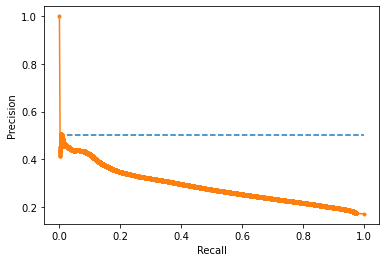

In [43]:
######Do the plot 

probs = y_pred_prob[:,1]

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)   
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('Average Precision %f' %ap)

# calculate precision-recall AUC
auc_area = auc(recall, precision)
print('precision-recall AUC %s' %auc_area)

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')

plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Title name')

# show the plot
plt.show()


### If happy with the model then save to file

In [48]:
modelname = "click_model_RF.sav"

In [45]:
pickle.dump(RFclassifier, open(modelname, 'wb'))
# pickle.dump(loaded_model, open(modelname, 'wb'))



# Predictions on unseen data

In [49]:
tmp = pd.read_csv("train") ### unseen data
tmp = tmp.drop_duplicates() ### Only unique records
data = tmp.iloc[0:2500, :].copy() ### trial of 2500 observations
del tmp

In [31]:

def recode_func(x, lst):
    res = 'Other'
    if (x in lst):
        res = x
    return res


### The missing values for f7 has a higher than click rate the overall average, hence it may prove worthwhile including it.

In [28]:
### function to change unix timestamp into datetime
def unix2datetime(x):
    timestamp = datetime.datetime.fromtimestamp(x)
    date_time_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S') #timestamp.strftime('%Y-%m-%d %H:%M:%S')

In [52]:

data["timeofclick"] = data["unix_timestamp"].apply(lambda x: unix2datetime(x))

In [53]:
data["weekday"] = data["timeofclick"].apply(lambda x: x.weekday())
data["hour"] = data["timeofclick"].apply(lambda x: x.hour)

### f variables. 

In [54]:
### Replace Nulls in f7 variable
# data["f7"] = np.where(data["f7"].isnull(), 99999, data["f7"])
### Found f7 only add value if null
data["f7"] = np.where(data["f7"].isnull(), 1, 0)

ls_fx = ["f"+str(i) for i in np.arange(9)]
    
### force f variables to object type    
for k in ls_fx:
    data[k] = data[k].astype(str)


# Encode all cat variables

In [55]:
%%time 

var = ['site_id', 'site_domain', 'app_id','app_category', 'device_id', 'device_model', 'f7']

for i in var:
    data[i] = data[i].replace(r'^\s*$', 'Other', regex=True) ###replace invalids with 'other'
    print('filename {}'.format(i+'.csv'))
    tmp = pd.read_csv(i+'.csv') ###read in the lu table
    data[i] = data[i].apply( lambda x: recode_func(x, tmp['Var'].values) ) ###recode the labels
    del tmp

categorical_features = var + ['ui_component_position', 'weekday', 'hour']
for i in categorical_features:
    data[i] = data[i].astype(str)
    


filename site_id.csv
filename site_domain.csv
filename app_id.csv
filename app_category.csv
filename device_id.csv
filename device_model.csv
filename f7.csv
CPU times: user 542 ms, sys: 19.8 ms, total: 562 ms
Wall time: 814 ms


In [56]:
X = data[categorical_features]
# y = data['click'] ### won't have this

### One hot encoding. Store the one hot encoder

In [57]:

### Encoder to use
encoder_name = "NB304916oheNOPCA_v01.p"
encoder = pickle.load(open(encoder_name, 'rb'))

X = encoder.transform(X)

In [58]:
### model to use
modelname = "click_model_RF.sav"

###load model
loaded_model = pickle.load(open(modelname, 'rb'))

In [59]:
### Predictions
y_pred = loaded_model.predict(X)